In [ ]:
!odsc data-catalog config --authentication resource_principal --metastore <metastore_id>

Oracle Data Science service sample notebook.

Copyright (c) 2022 Oracle, Inc. All rights reserved. Licensed under the [Universal Permissive License v 1.0](https://oss.oracle.com/licenses/upl).

***

# <font color="red">Feature Engineering for medical data in Feature store </font>
<p style="margin-left:10%; margin-right:10%;">by the <font color="teal">Oracle Cloud Infrastructure Data Science Service.</font></p>

---
# Overview:
---
Managing many datasets, data-sources and transformations for machine learning is complex and costly. Poorly cleaned data, data issues, bugs in transformations, data drift and training serving skew all leads to increased model development time and worse model performance. Here, feature store is well positioned to solve many of the problems since it provides a centralised way to transform and access data for training and serving time and helps defines a standardised pipeline for ingestion of data and querying of data. This notebook demonstrates how to use feature store within a long lasting [Oracle Cloud Infrastructure Data Flow](https://docs.oracle.com/en-us/iaas/data-flow/using/home.htm) cluster.

Compatible conda pack: [PySpark 3.2 and Feature store](https://docs.oracle.com/iaas/data-science/using/conda-pyspark-fam.htm) for CPU on Python 3.8

<div>
    <img src="https://objectstorage.us-ashburn-1.oraclecloud.com/p/hh2NOgFJbVSg4amcLM3G3hkTuHyBD-8aE_iCsuZKEvIav1Wlld-3zfCawG4ycQGN/n/ociodscdev/b/oci-feature-store/o/beta/_images/overview-roles.png"  />
</div>

## Contents:

- <a href="#concepts">1. Introduction</a>
- <a href='#pre-requisites'>1. Pre-requisites</a>
    - <a href='#policies'>2.1 Policies</a>
    - <a href='#prerequisites_authentication'>2.2 Authentication</a>
    - <a href='#prerequisites_variables'>2.3 Variables</a>
- <a href='#featurestore_querying'>3. Feature store querying</a>
    - <a href='#data_exploration'>3.1. Exploration of data in feature store</a>
    - <a href='#load_featuregroup'>3.2. Load feature groups</a>
    - <a href='#explore_featuregroup'>3.3. Explore feature groups</a>
    - <a href='#select_subset_featuregroup'>3.4. Select subset of features</a>
    - <a href='#filter_featuregroup'>3.5. Filter feature groups</a>
    - <a href='#join_featuregroup'>3.6. Apply joins on feature group</a>
    - <a href='#create_dataset'>3.7. Create dataset from multiple or one feature group</a>
    - <a href='#sql_query'>3.8 Free form sql query</a>
- <a href='#ref'>4. References</a>

---

**Important:**

Placeholder text for required values are surrounded by angle brackets that must be removed when adding the indicated content. For example, when adding a database name to `database_name = "<database_name>"` would become `database_name = "production"`.

---

<a id="concepts"></a>
# 1. Introduction

Oracle feature store is a stack based solution that is deployed in the customer enclave using OCI resource manager. Customer can stand up the service with infrastructure in their own tenancy. The service consists of API which are deployed in customer tenancy using resource manager.

The following are some key terms that will help you understand OCI Data Science Feature Store:


* **Feature Vector**: Set of feature values for any one primary/identifier key. Eg. All/subset of features of customer id ‘2536’ can be called as one feature vector.

* **Feature**: A feature is an individual measurable property or characteristic of a phenomenon being observed.

* **Entity**: An entity is a group of semantically related features. The first step a consumer of features would typically do when accessing the feature store service is to list the entities and the entities associated features. Another way to look at it is that an entity is an object or concept that is described by its features. Examples of entities could be customer, product, transaction, review, image, document, etc.

* **Feature Group**: A feature group in a feature store is a collection of related features that are often used together in ml models. It serves as an organizational unit within the feature store for users to manage, version and share features across different ml projects. By organizing features into groups, data scientists and ml engineers can efficiently discover, reuse and collaborate on features reducing the redundant work and ensuring consistency in feature engineering.

* **Feature Group Job**: Feature group job is the execution instance of a feature group. Each feature group job will include validation results and statistics results.

* **Dataset**: A dataset is a collection of feature that are used together to either train a model or perform model inference.

* **Dataset Job**: Dataset job is the execution instance of a dataset. Each dataset job will include validation results and statistics results.

<a id='pre-requisites'></a>
# 2. Pre-requisites

Data Flow Sessions are accessible through the following conda environment:

* **PySpark 3.2, Feature store 1.0 and Data Flow 1.0 (fs_pyspark32_p38_cpu_v1)**

The [Data Catalog Hive Metastore](https://docs.oracle.com/en-us/iaas/data-catalog/using/metastore.htm) provides schema definitions for objects in structured and unstructured data assets. The Metastore is the central metadata repository to understand tables backed by files on object storage. You can customize `fs_pyspark32_p38_cpu_v1`, publish it, and use it as a runtime environment for a Data Flow session cluster. The metastore id of hive metastore is tied to feature store construct of feature store service.


<a id='setup_spark-defaults'></a>
### `spark-defaults.conf`

The `spark-defaults.conf` file is used to define the properties that are used by Spark. A templated version is installed when you install a Data Science conda environment that supports PySpark. However, you must update the template so that the Data Catalog metastore can be accessed. You can do this manually. However, the `odsc data-catalog config` commandline tool is ideal for setting up the file because it gathers information about your environment, and uses that to build the file.

The `odsc data-catalog config` command line tool needs the `--metastore` option to define the Data Catalog metastore OCID. No other command line option is needed because settings have default values, or they take values from your notebook session environment. Following are common parameters that you may need to override.

The `--authentication` option sets the authentication mode. It supports resource principal and API keys. The preferred method for authentication is resource principal, which is sent with `--authentication resource_principal`. If you want to use API keys, then use the `--authentication api_key` option. If the `--authentication` isn't specified, API keys are used. When API keys are used, information from the OCI configuration file is used to create the `spark-defaults.conf` file.

Object Storage and Data Catalog are regional services. By default, the region is set to the region your notebook session is running in. This information is taken from the environment variable, `NB_REGION`. Use the `--region` option to override this behavior.

The default location of the `spark-defaults.conf` file is `/home/datascience/spark_conf_dir` as defined in the `SPARK_CONF_DIR` environment variable. Use the `--output` option to define the directory where to write the file.

You need to determine what settings are appropriate for your configuration. However, the following works for most configurations and is run in a terminal window.

```bash
odsc data-catalog config --authentication resource_principal --metastore <metastore_id>
```
For more assistance, use the following command in a terminal window:

```bash
odsc data-catalog config --help
```

<a id='setup_session'></a>
### Session Setup

The notebook makes connections to the Data Catalog metastore and Object Storage. In the next cell, specify the bucket URI to act as the data warehouse. Use the `warehouse_uri` variable with the `oci://<bucket_name>@<namespace_name>/<key>` format. Update the variable `metastore_id` with the OCID of the Data Catalog metastore.

<a id='policies'></a>
### 2.1. Policies
This section covers the creation of dynamic groups and policies needed to use the service.

* [Data Flow Policies](https://docs.oracle.com/iaas/data-flow/using/policies.htm/)
* [Data Catalog Metastore Required Policies](https://docs.oracle.com/en-us/iaas/data-catalog/using/metastore.htm)
* [Getting Started with Data Flow](https://docs.oracle.com/iaas/data-flow/using/dfs_getting_started.htm)
* [About Data Science Policies](https://docs.oracle.com/iaas/data-science/using/policies.htm)

<a id="prerequisites_authentication"></a>
### 2.2. Authentication
The [Oracle Accelerated Data Science SDK (ADS)](https://docs.oracle.com/iaas/tools/ads-sdk/latest/index.html) controls the authentication mechanism with the notebook cluster.<br>
To setup authentication use the ```ads.set_auth("resource_principal")``` or ```ads.set_auth("api_key")```.

In [1]:
import ads
ads.set_auth(auth="resource_principal", client_kwargs={"fs_service_endpoint": "https://pxch6velt3jybrrmzja7p74bam.apigateway.us-ashburn-1.oci.customer-oci.com/20230101"})

<a id="prerequisites_variables"></a>
### 2.3. Variables
To run this notebook, you must provide some information about your tenancy configuration. To create and run a feature store, you must specify a `<compartment_id>` and bucket `<metastore_id>` for offline feature store.

In [2]:
import os

compartment_id = os.environ.get("NB_SESSION_COMPARTMENT_OCID")
metastore_id = "ocid1.datacatalogmetastore.oc1.iad.amaaaaaabiudgxya2ipeqjr2m7npnn3kboq4s27erl3ts56wggl6ls6gpn3q"

<a id="featurestore_querying"></a>
# 3. Feature group querying
By default the **PySpark 3.2, Feature store and Data Flow** conda environment includes pre-installed [great-expectations](https://legacy.docs.greatexpectations.io/en/latest/reference/core_concepts/validation.html) and OCI ML monitoring libraries. The joining functionality is heavily inspired by the APIs used by Pandas to merge, join or filter DataFrames. The APIs allow you to specify which features to select from which feature group, how to join them and which features to use in join conditions.



In [3]:
import pandas as pd
from ads.feature_store.feature_store import FeatureStore
from ads.feature_store.feature_group import FeatureGroup
from ads.feature_store.model_details import ModelDetails
from ads.feature_store.dataset import Dataset
from ads.feature_store.common.enums import DatasetIngestionMode

from ads.feature_store.feature_group_expectation import ExpectationType
from great_expectations.core import ExpectationSuite, ExpectationConfiguration
from ads.feature_store.feature_store_registrar import FeatureStoreRegistrar

  from .model_deployment_properties import ModelDeploymentProperties

  from .model_deployer import ModelDeployer

  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):

  if LooseVersion(pyarrow.__version__) < LooseVersion(minimum_pyarrow_version):

  LooseVersion(pyarrow.__version__) >= LooseVersion("2.0.0")

  if LooseVersion(pd.__version__) >= LooseVersion("0.24"):

  if LooseVersion(pd.__version__) < LooseVersion("1.0"):

  if LooseVersion(pd.__version__) < LooseVersion("1.0"):

  if LooseVersion(pd.__version__) < LooseVersion("1.0"):

  if LooseVersion(pd.__version__) < LooseVersion("1.0"):

  if LooseVersion(pd.__version__) >= LooseVersion("1.3.0"):

Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore

Implementing implicit na

<a id="data_exploration"></a>
### 3.1. Exploration of data in feature store

The dataset contains Electronic Health Record predictions collected from a private Hospital in Indonesia. It contains the patient's laboratory test results used to determine the next patient's treatment whether in care or out care.


In [4]:
patient_result_df = pd.read_csv("https://objectstorage.us-ashburn-1.oraclecloud.com/p/hh2NOgFJbVSg4amcLM3G3hkTuHyBD-8aE_iCsuZKEvIav1Wlld-3zfCawG4ycQGN/n/ociodscdev/b/oci-feature-store/o/beta/data/EHR/data-ori.csv")
patient_result_df.head()

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,35.1,11.8,4.65,6.3,310,25.4,33.6,75.5,1,F,out
1,43.5,14.8,5.39,12.7,334,27.5,34.0,80.7,1,F,out
2,33.5,11.3,4.74,13.2,305,23.8,33.7,70.7,1,F,out
3,39.1,13.7,4.98,10.5,366,27.5,35.0,78.5,1,F,out
4,30.9,9.9,4.23,22.1,333,23.4,32.0,73.0,1,M,out


#### Dataset Overview 

In [5]:
print(f"The dataset contains {patient_result_df.shape[0]} rows and {patient_result_df.shape[1]} columns")

# get all the features
features = [feat for feat in patient_result_df.columns if feat !='SOURCE']
num_features = [feat for feat in features if patient_result_df[feat].dtype != object]
cat_features = [feat for feat in features if patient_result_df[feat].dtype == object]

print(f"Total number of features : {len(features)}")
print(f"Number of numerical features : {len(num_features)}")
print(f"Number of categorical features : {len(cat_features)}\n")

The dataset contains 4412 rows and 11 columns
Total number of features : 10
Number of numerical features : 9
Number of categorical features : 1



<b> Missing Values</b>

In [6]:
patient_result_df.isna().mean().to_frame(name='Missing %')

,Missing %
HAEMATOCRIT,0.0
HAEMOGLOBINS,0.0
ERYTHROCYTE,0.0
LEUCOCYTE,0.0
THROMBOCYTE,0.0
MCH,0.0
MCHC,0.0
MCV,0.0
AGE,0.0
SEX,0.0


<b>Unique Values</b>

In [7]:
patient_result_df.nunique().to_frame(name='# of unique values')

,# of unique values
HAEMATOCRIT,326
HAEMOGLOBINS,128
ERYTHROCYTE,433
LEUCOCYTE,276
THROMBOCYTE,554
MCH,189
MCHC,105
MCV,406
AGE,95
SEX,2


<a id="load_featuregroup"></a>
### 3.2. Create feature store logical entities

#### 3.2.1 Feature Store
Feature store is the top level entity for feature store service

In [8]:
feature_store_resource = (
    FeatureStore().
    with_description("Electronic Heath Data consisting of Patient Test Results").
    with_compartment_id(compartment_id).
    with_display_name("EHR details").
    with_offline_config(metastore_id=metastore_id)
)

<a id="create_feature_store"></a>
##### Create Feature Store

Call the ```.create()``` method of the Feature store instance to create a feature store.

In [9]:
feature_store = feature_store_resource.create()
feature_store


kind: featurestore
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  description: Electronic Heath Data consisting of Patient Test Results
  displayName: EHR details
  id: B5D18A2B5D08F462AC230FBEAF9032BF
  offlineConfig:
    metastoreId: ocid1.datacatalogmetastore.oc1.iad.amaaaaaabiudgxya2ipeqjr2m7npnn3kboq4s27erl3ts56wggl6ls6gpn3q
type: featureStore

#### 3.2.2 Entity
An entity is a group of semantically related features.

In [10]:
entity = feature_store.create_entity(
    display_name="EHR",
    description="Electronic Health Record predictions"
)
entity


kind: entity
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  description: Electronic Health Record predictions
  featureStoreId: B5D18A2B5D08F462AC230FBEAF9032BF
  id: AA52BA1722E547CE8B83607D5F6CE55B
  name: EHR
type: entity

#### 3.2.3 Transformation
Transformations in a feature store refers to the operations and processes applied to raw data to create, modify or derive new features that can be used as inputs for ML Models


Below python function defines 2 PANDAS transformations which are used for feature engineering.<code>label_encoder_transformation</code> performs label encoding to convert  categorical variables into numerical format. It take the column label as input keyword argument that needs to be encoded. Another transformation is  <code>min_max_scaler</code> which scale the features to a range of 0 to 1<br>
<code>chained_transformation</code> chains both of these transformation by first performing imputation and then
doing label encoding on the returned dataframe.

In [11]:
def chained_transformation(patient_result_df, **transformation_args):
    def label_encoder_transformation(patient_result_df, **transformation_args):
        from sklearn.preprocessing import LabelEncoder
        # creating instance of labelencoder
        labelencoder = LabelEncoder()
        result_df = patient_result_df.copy()
        column_labels= transformation_args.get("label_encode_column")
        if isinstance(column_labels,list):
            for col in column_labels:
                result_df[col] = labelencoder.fit_transform(result_df[col])
        elif isinstance(column_labels, str):
             result_df[column_labels] = labelencoder.fit_transform(result_df[column_labels])
        else:
            return None
        return result_df
    
    def min_max_scaler(patient_result_df, **transformation_args):
        from sklearn.preprocessing import MinMaxScaler
        final_result_df = patient_result_df.copy()
        scaler = MinMaxScaler(feature_range=(0, 1))
        column_labels= transformation_args.get("scaling_column_labels")
        final_result_df[column_labels] = scaler.fit_transform(final_result_df[column_labels])
        return patient_result_df
    
    def feature_removal(input_df, **transformation_args):
        output_df = input_df.copy()
        output_df.drop(transformation_args.get("redundant_feature_label"), axis=1, inplace=True)
        return output_df

    out1 = label_encoder_transformation(patient_result_df, **transformation_args)
    out2 = min_max_scaler(out1, **transformation_args)
    return feature_removal(out2, **transformation_args)

In [12]:
transformation_args = {
    "label_encode_column": ["SEX","SOURCE"],
    "scaling_column_labels": num_features,
    "redundant_feature_label": ["MCH", "MCHC", "MCV"]
}


In [13]:
from ads.feature_store.transformation import Transformation,TransformationMode

transformation = (
    Transformation()
    .with_display_name("chained_transformation")
    .with_feature_store_id(feature_store.id)
    .with_source_code_function(chained_transformation)
    .with_transformation_mode(TransformationMode.PANDAS)
    .with_description("transformation to perform feature engineering")
    .with_compartment_id(compartment_id)
)

transformation.create()


kind: transformation
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  description: transformation to perform feature engineering
  displayName: chained_transformation
  featureStoreId: B5D18A2B5D08F462AC230FBEAF9032BF
  id: 37E3C80B27B814591B072EFC53FABE4E
  sourceCode: ZGVmIGNoYWluZWRfdHJhbnNmb3JtYXRpb24ocGF0aWVudF9yZXN1bHRfZGYsICoqdHJhbnNmb3JtYXRpb25fYXJncyk6CiAgICBkZWYgbGFiZWxfZW5jb2Rlcl90cmFuc2Zvcm1hdGlvbihwYXRpZW50X3Jlc3VsdF9kZiwgKip0cmFuc2Zvcm1hdGlvbl9hcmdzKToKICAgICAgICBmcm9tIHNrbGVhcm4ucHJlcHJvY2Vzc2luZyBpbXBvcnQgTGFiZWxFbmNvZGVyCiAgICAgICAgIyBjcmVhdGluZyBpbnN0YW5jZSBvZiBsYWJlbGVuY29kZXIKICAgICAgICBsYWJlbGVuY29kZXIgPSBMYWJlbEVuY29kZXIoKQogICAgICAgIHJlc3VsdF9kZiA9IHBhdGllbnRfcmVzdWx0X2RmLmNvcHkoKQogICAgICAgIGNvbHVtbl9sYWJlbHM9IHRyYW5zZm9ybWF0aW9uX2FyZ3MuZ2V0KCJsYWJlbF9lbmNvZGVfY29sdW1uIikKICAgICAgICBpZiBpc2luc3RhbmNlKGNvbHVtbl9sYWJlbHMsbGlzdCk6CiAgICAgICAgICAgIGZvciBjb2wgaW4gY29sdW1uX2xhYmVsczoKICAgICAgICAgICAgICAgIHJlc3Vs

#### 3.2.3 Feature group
A feature group is an object that represents a logical group of time-series feature data as it is found in a datasource.

<a id="create_feature_group_ehr"></a>
##### Patient's EHR Feature Group

Create feature group for EHR

<div>
    <img src="https://objectstorage.us-ashburn-1.oraclecloud.com/p/hh2NOgFJbVSg4amcLM3G3hkTuHyBD-8aE_iCsuZKEvIav1Wlld-3zfCawG4ycQGN/n/ociodscdev/b/oci-feature-store/o/beta/_images/feature_group_flights.gif" width="700" height="350" />
</div>

In [14]:
feature_group_ehr = (
    FeatureGroup()
    .with_feature_store_id(feature_store.id)
    .with_primary_keys([])
    .with_name("ehr_feature_group")
    .with_entity_id(entity.id)
    .with_compartment_id(compartment_id)
    .with_schema_details_from_dataframe(patient_result_df)
    .with_transformation_id(transformation.id)
    .with_transformation_kwargs(transformation_args)
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2023/12/12 03:54:43 NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):

  if LooseVersion(pyarrow.__version__) < LooseVersion(minimum_pyarrow_version):

  arrow_data = [[(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]



In [15]:
feature_group_ehr.create()


kind: FeatureGroup
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  entityId: AA52BA1722E547CE8B83607D5F6CE55B
  featureStoreId: B5D18A2B5D08F462AC230FBEAF9032BF
  id: BE716DA76DD4E94BBE745C02FA582318
  inputFeatureDetails:
  - featureType: DOUBLE
    name: HAEMATOCRIT
    orderNumber: 1
  - featureType: DOUBLE
    name: HAEMOGLOBINS
    orderNumber: 2
  - featureType: DOUBLE
    name: ERYTHROCYTE
    orderNumber: 3
  - featureType: DOUBLE
    name: LEUCOCYTE
    orderNumber: 4
  - featureType: LONG
    name: THROMBOCYTE
    orderNumber: 5
  - featureType: DOUBLE
    name: MCH
    orderNumber: 6
  - featureType: DOUBLE
    name: MCHC
    orderNumber: 7
  - featureType: DOUBLE
    name: MCV
    orderNumber: 8
  - featureType: LONG
    name: AGE
    orderNumber: 9
  - featureType: STRING
    name: SEX
    orderNumber: 10
  - featureType: STRING
    name: SOURCE
    orderNumber: 11
  isInferSchema: true
  name: ehr_feature_group
  p

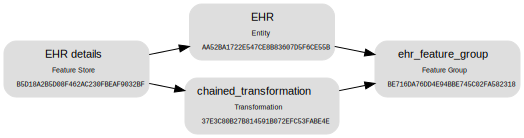

In [16]:
feature_group_ehr.show()

##### Expectations

Update feature group with expectations

In [17]:
expectation_suite_ehr = ExpectationSuite(
    expectation_suite_name="test_hcm_df"
)
expectation_suite_ehr.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_not_be_null",
        kwargs={"column": "AGE"},
    )
)
expectation_suite_ehr.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_be_between",
        kwargs={"column": "HAEMOGLOBINS", "min_value": 0, "max_value": 30},
    )
)

{"expectation_type": "expect_column_values_to_be_between", "kwargs": {"column": "HAEMOGLOBINS", "min_value": 0, "max_value": 30}, "meta": {}}

In [18]:
from ads.feature_store.common.enums import ExpectationType

feature_group_ehr.with_expectation_suite(expectation_suite_ehr, expectation_type = ExpectationType.STRICT)
feature_group_ehr.update()


kind: FeatureGroup
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  entityId: AA52BA1722E547CE8B83607D5F6CE55B
  expectationDetails:
    createRuleDetails:
    - arguments:
        column: AGE
      levelType: ERROR
      name: Rule-0
      ruleType: expect_column_values_to_not_be_null
    - arguments:
        column: HAEMOGLOBINS
        max_value: 30
        min_value: 0
      levelType: ERROR
      name: Rule-1
      ruleType: expect_column_values_to_be_between
    expectationType: STRICT
    name: test_hcm_df
    validationEngineType: GREAT_EXPECTATIONS
  featureStoreId: B5D18A2B5D08F462AC230FBEAF9032BF
  id: BE716DA76DD4E94BBE745C02FA582318
  inputFeatureDetails:
  - featureType: DOUBLE
    name: HAEMATOCRIT
    orderNumber: 1
  - featureType: DOUBLE
    name: HAEMOGLOBINS
    orderNumber: 2
  - featureType: DOUBLE
    name: ERYTHROCYTE
    orderNumber: 3
  - featureType: DOUBLE
    name: LEUCOCYTE
    orderNumber: 4
  - fea

In [19]:
feature_group_ehr.materialise(patient_result_df)

Hive Session ID = a59ce864-7c1c-4778-bca5-097b184bf500


INFO:great_expectations.validator.validator:	2 expectation(s) included in expectation_suite.


Calculating Metrics:   0%|          | 0/11 [00:00<?, ?it/s]

INFO:ads.feature_store.common.utils.utility:Validation Summary 
╒════════════════════╤══════════════════════════╤═══════════════════════════╤═════════════════════════════╤═══════════════════╤═══════════════════════╕
│  expectation_type  │  evaluated_expectations  │  successful_expectations  │  unsuccessful_expectations  │  success_percent  │   ingestion_status    │
╞════════════════════╪══════════════════════════╪═══════════════════════════╪═════════════════════════════╪═══════════════════╪═══════════════════════╡
│       STRICT       │            2             │             2             │              0              │        100        │ Ingestion in progress │
╘════════════════════╧══════════════════════════╧═══════════════════════════╧═════════════════════════════╧═══════════════════╧═══════════════════════╛
INFO:ads.feature_store.common.utils.utility:Validations Rules Summary 
╒═════════════════════════════════════╤═════════════════════════════════════════════════════════════╤════

INFO:ads.feature_store.common.utils.utility:Ingestion Summary 
╒══════════════════════════════════╤═══════════════╤════════════════════╤═════════════════╕
│            entity_id             │  entity_type  │  ingestion_status  │  error_details  │
╞══════════════════════════════════╪═══════════════╪════════════════════╪═════════════════╡
│ BE716DA76DD4E94BBE745C02FA582318 │ FEATURE_GROUP │     Succeeded      │      None       │
╘══════════════════════════════════╧═══════════════╧════════════════════╧═════════════════╛


<a id="explore_featuregroup"></a>
### 3.3. Explore feature groups

In [20]:
feature_group_ehr.get_features_df()

,name,type
0,HAEMATOCRIT,DOUBLE
1,HAEMOGLOBINS,DOUBLE
2,ERYTHROCYTE,DOUBLE
3,LEUCOCYTE,DOUBLE
4,THROMBOCYTE,LONG
5,AGE,LONG
6,SEX,LONG
7,SOURCE,LONG


In [21]:
feature_group_ehr.select().show()

+-----------+------------+-----------+---------+-----------+---+---+------+
|HAEMATOCRIT|HAEMOGLOBINS|ERYTHROCYTE|LEUCOCYTE|THROMBOCYTE|AGE|SEX|SOURCE|
+-----------+------------+-----------+---------+-----------+---+---+------+
|       33.8|        11.2|        4.0|      9.0|        140| 47|  0|     0|
|       39.5|        13.2|       4.55|      2.3|         74| 47|  0|     0|
|       31.6|         9.6|       4.52|      7.9|        301| 47|  0|     0|
|       33.1|        10.9|       3.97|      8.2|        143| 47|  0|     0|
|       39.3|        13.3|       4.49|      3.3|         50| 47|  0|     0|
|       40.1|        12.2|       5.53|      6.4|        326| 47|  0|     0|
|       39.7|        12.7|       4.63|      4.0|        167| 47|  1|     0|
|       25.0|         8.1|        3.1|      5.3|        125| 47|  1|     0|
|       26.4|         8.0|        3.1|     10.0|         64| 47|  1|     0|
|       33.1|        11.5|       3.94|     13.3|        248| 47|  1|     0|
+-----------

In [22]:
feature_group_ehr.get_statistics().to_pandas()

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,AGE,SEX,SOURCE
Skewness,"{'metric_name': 'Skewness', 'metric_description': 'Feature Metric to compute Skewness', 'variable_count': 1, 'variable_names': ['skewness'], 'variable_types': ['CONTINUOUS'], 'variable_dtypes': ['FLOAT'], 'variable_dimensions': [0], 'metric_data': [-0.30371526085897005], 'metadata': {}}","{'metric_name': 'Skewness', 'metric_description': 'Feature Metric to compute Skewness', 'variable_count': 1, 'variable_names': ['skewness'], 'variable_types': ['CONTINUOUS'], 'variable_dtypes': ['FLOAT'], 'variable_dimensions': [0], 'metric_data': [-0.312333213182426], 'metadata': {}}","{'metric_name': 'Skewness', 'metric_description': 'Feature Metric to compute Skewness', 'variable_count': 1, 'variable_names': ['skewness'], 'variable_types': ['CONTINUOUS'], 'variable_dtypes': ['FLOAT'], 'variable_dimensions': [0], 'metric_data': [-0.007433477628864001], 'metadata': {}}","{'metric_name': 'Skewness', 'metric_description': 'Feature Metric to compute Skewness', 'variable_count': 1, 'variable_names': ['skewness'], 'variable_types': ['CONTINUOUS'], 'variable_dtypes': ['FLOAT'], 'variable_dimensions': [0], 'metric_data': [2.791606961929011], 'metadata': {}}","{'metric_name': 'Skewness', 'metric_description': 'Feature Metric to compute Skewness', 'variable_count': 1, 'variable_names': ['skewness'], 'variable_types': ['CONTINUOUS'], 'variable_dtypes': ['FLOAT'], 'variable_dimensions': [0], 'metric_data': [0.8452104901645501], 'metadata': {}}","{'metric_name': 'Skewness', 'metric_description': 'Feature Metric to compute Skewness', 'variable_count': 1, 'variable_names': ['skewness'], 'variable_types': ['CONTINUOUS'], 'variable_dtypes': ['FLOAT'], 'variable_dimensions': [0], 'metric_data': [-0.12448168156378502], 'metadata': {}}","{'metric_name': 'Skewness', 'metric_description': 'Feature Metric to compute Skewness', 'variable_count': 1, 'variable_names': ['skewness'], 'variable_types': ['CONTINUOUS'], 'variable_dtypes': ['FLOAT'], 'variable_dimensions': [0], 'metric_data': [-0.07621120891710201], 'metadata': {}}","{'metric_name': 'Skewness', 'metric_description': 'Feature Metric to compute Skewness', 'variable_count': 1, 'variable_names': ['skewness'], 'variable_types': ['CONTINUOUS'], 'variable_dtypes': ['FLOAT'], 'variable_dimensions': [0], 'metric_data': [-0.38979147911674406], 'metadata': {}}"
StandardDeviation,"{'metric_name': 'StandardDeviation', 'metric_description': 'Feature Metric to compute Standard Deviation', 'variable_count': 1, 'variable_names': ['standard_deviation'], 'variable_types': ['CONTINUOUS'], 'variable_dtypes': ['FLOAT'], 'variable_dimensions': [0], 'metric_data': [5.974107330011201], 'metadata': {}}","{'metric_name': 'StandardDeviation', 'metric_description': 'Feature Metric to compute Standard Deviation', 'variable_count': 1, 'variable_names': ['standard_deviation'], 'variable_types': ['CONTINUOUS'], 'variable_dtypes': ['FLOAT'], 'variable_dimensions': [0], 'metric_data': [2.079667141984532], 'metadata': {}}","{'metric_name': 'StandardDeviation', 'metric_description': 'Feature Metric to compute Standard Deviation', 'variable_count': 1, 'variable_names': ['standard_deviation'], 'variable_types': ['CONTINUOUS'], 'variable_dtypes': ['FLOAT'], 'variable_dimensions': [0], 'metric_data': [0.7840023881508601], 'metadata': {}}","{'metric_name': 'StandardDeviation', 'metric_description': 'Feature Metric to compute Standard Deviation', 'variable_count': 1, 'variable_names': ['standard_deviation'], 'variable_types': ['CONTINUOUS'], 'variable_dtypes': ['FLOAT'], 'variable_dimensions': [0], 'metric_data': [5.048468665770701], 'metadata': {}}","{'metric_name': 'StandardDeviation', 'metric_description': 'Feature Metric to compute Standard Deviation', 'variable_count': 1, 'variable_names': ['standard_deviation'], 'variable_types': ['CONTINUOUS'], 'variable_dtypes': ['FLOAT'], 'variable_dimensions': [0], 'metric_data': [113.95944781860656], 'metadata': {}}","{

In [23]:
feature_group_ehr.get_validation_output().to_pandas()

,0,1
success,True,True
expectation_config.expectation_type,expect_column_values_to_not_be_null,expect_column_values_to_be_between
expectation_config.kwargs.column,AGE,HAEMOGLOBINS
expectation_config.kwargs.batch_id,7fd249029a1b247d18e2b509ae8e8fcb,7fd249029a1b247d18e2b509ae8e8fcb
result.element_count,4412,4412
result.unexpected_count,0,0
result.unexpected_percent,0.0,0.0
result.partial_unexpected_list,[],[]
exception_info.raised_exception,False,False
exception_info.exception_traceback,None,None


<a id="select_subset_featuregroup"></a>
### 3.4. Select subset of features

In [24]:
feature_group_ehr.select(['AGE', 'SEX', 'SOURCE']).show()

+---+---+------+
|AGE|SEX|SOURCE|
+---+---+------+
| 47|  0|     0|
| 47|  0|     0|
| 47|  0|     0|
| 47|  0|     0|
| 47|  0|     0|
| 47|  0|     0|
| 47|  1|     0|
| 47|  1|     0|
| 47|  1|     0|
| 47|  1|     0|
+---+---+------+
only showing top 10 rows



<a id="filter_featuregroup"></a>
### 3.5. Filter feature groups

In [25]:
feature_group_ehr.filter(feature_group_ehr.SOURCE == "1").show()

+-----------+------------+-----------+---------+-----------+---+---+------+
|HAEMATOCRIT|HAEMOGLOBINS|ERYTHROCYTE|LEUCOCYTE|THROMBOCYTE|AGE|SEX|SOURCE|
+-----------+------------+-----------+---------+-----------+---+---+------+
|       35.8|        12.7|       4.14|      5.6|        329| 48|  0|     1|
|       36.8|        13.5|       4.77|     23.3|        409| 48|  0|     1|
|       40.2|        13.5|        4.4|      4.1|        166| 48|  0|     1|
|       42.5|        14.1|        4.7|      8.0|        291| 48|  0|     1|
|       46.2|        15.8|       5.62|     11.9|        254| 48|  1|     1|
|       40.1|        13.7|       4.81|      4.6|        192| 48|  1|     1|
|       39.2|        13.0|       4.56|      5.2|        232| 48|  1|     1|
|       44.6|        15.5|       5.35|      9.0|        341| 48|  1|     1|
|       36.5|        12.1|       4.21|      8.0|        407| 48|  0|     1|
|       43.7|        15.0|       5.44|      5.1|        180| 48|  0|     1|
+-----------

<a id="create_dataset"></a>
### 3.7 Create dataset
A dataset is a collection of feature snapshots that are joined together to either train a model or perform model inference.

<div>
    <img src="https://objectstorage.us-ashburn-1.oraclecloud.com/p/hh2NOgFJbVSg4amcLM3G3hkTuHyBD-8aE_iCsuZKEvIav1Wlld-3zfCawG4ycQGN/n/ociodscdev/b/oci-feature-store/o/beta/_images/fs_ehr_dataset.gif" width="700" height="350" />
</div>

In [26]:
query = feature_group_ehr.select() 
query.show()

+-----------+------------+-----------+---------+-----------+---+---+------+
|HAEMATOCRIT|HAEMOGLOBINS|ERYTHROCYTE|LEUCOCYTE|THROMBOCYTE|AGE|SEX|SOURCE|
+-----------+------------+-----------+---------+-----------+---+---+------+
|       33.8|        11.2|        4.0|      9.0|        140| 47|  0|     0|
|       39.5|        13.2|       4.55|      2.3|         74| 47|  0|     0|
|       31.6|         9.6|       4.52|      7.9|        301| 47|  0|     0|
|       33.1|        10.9|       3.97|      8.2|        143| 47|  0|     0|
|       39.3|        13.3|       4.49|      3.3|         50| 47|  0|     0|
|       40.1|        12.2|       5.53|      6.4|        326| 47|  0|     0|
|       39.7|        12.7|       4.63|      4.0|        167| 47|  1|     0|
|       25.0|         8.1|        3.1|      5.3|        125| 47|  1|     0|
|       26.4|         8.0|        3.1|     10.0|         64| 47|  1|     0|
|       33.1|        11.5|       3.94|     13.3|        248| 47|  1|     0|
+-----------

In [27]:
dataset = (
    Dataset()
    .with_description("Combined dataset for EHR")
    .with_compartment_id(compartment_id)
    .with_name("ehr_dataset")
    .with_entity_id(entity.id)
    .with_feature_store_id(feature_store.id)
    .with_query(query.to_string())
)

<a id="create_dataset"></a>
##### Create Dataset

Call the ```.create()``` method of the Dataset instance to create a dataset.

In [28]:
dataset.create()


kind: Dataset
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  datasetFeatureGroups:
    isManualAssociation: false
    items:
    - featureGroupId: BE716DA76DD4E94BBE745C02FA582318
  description: Combined dataset for EHR
  entityId: AA52BA1722E547CE8B83607D5F6CE55B
  featureStoreId: B5D18A2B5D08F462AC230FBEAF9032BF
  id: BE0E61AAAC57CDC347BE131E2B1F1A0D
  lifecycleState: ACTIVE
  modelDetails: {}
  name: ehr_dataset
  outputFeatureDetails:
    items: []
  query: SELECT fg_0.HAEMATOCRIT HAEMATOCRIT, fg_0.HAEMOGLOBINS HAEMOGLOBINS, fg_0.ERYTHROCYTE
    ERYTHROCYTE, fg_0.LEUCOCYTE LEUCOCYTE, fg_0.THROMBOCYTE THROMBOCYTE, fg_0.AGE
    AGE, fg_0.SEX SEX, fg_0.SOURCE SOURCE FROM `AA52BA1722E547CE8B83607D5F6CE55B`.ehr_feature_group
    fg_0
  statisticsConfig:
    isEnabled: true
type: dataset

In [29]:
dataset.materialise()

  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):

  if LooseVersion(pyarrow.__version__) < LooseVersion(minimum_pyarrow_version):



INFO:ads.feature_store.common.utils.utility:Ingestion Summary 
╒══════════════════════════════════╤═══════════════╤════════════════════╤═════════════════╕
│            entity_id             │  entity_type  │  ingestion_status  │  error_details  │
╞══════════════════════════════════╪═══════════════╪════════════════════╪═════════════════╡
│ BE0E61AAAC57CDC347BE131E2B1F1A0D │    DATASET    │     Succeeded      │      None       │
╘══════════════════════════════════╧═══════════════╧════════════════════╧═════════════════╛


### Interoperability with model

In [30]:
model_details = ModelDetails().with_items(["ocid1.datasciencemodel.oc1.iad.unique_id"])
dataset.add_models(model_details)


kind: Dataset
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  datasetFeatureGroups:
    isManualAssociation: false
    items:
    - featureGroupId: BE716DA76DD4E94BBE745C02FA582318
  description: Combined dataset for EHR
  entityId: AA52BA1722E547CE8B83607D5F6CE55B
  featureStoreId: B5D18A2B5D08F462AC230FBEAF9032BF
  id: BE0E61AAAC57CDC347BE131E2B1F1A0D
  jobId: 89588f6e-0f2d-4b00-8ae0-b635fff3964d
  lifecycleState: ACTIVE
  modelDetails:
    items:
    - ocid1.datasciencemodel.oc1.iad.amaaaaaabiudgxyaoggzrpcpgvjb7u2oh7wjoho3u6km6wweppv6mcaxnv2q
  name: ehr_dataset
  outputFeatureDetails:
    items:
    - datasetId: BE0E61AAAC57CDC347BE131E2B1F1A0D
      featureType: DOUBLE
      name: HAEMATOCRIT
    - datasetId: BE0E61AAAC57CDC347BE131E2B1F1A0D
      featureType: DOUBLE
      name: HAEMOGLOBINS
    - datasetId: BE0E61AAAC57CDC347BE131E2B1F1A0D
      featureType: DOUBLE
      name: ERYTHROCYTE
    - datasetId: BE0E61AAAC57CDC34

<a id="visualise_lineage"></a>
##### Visualise lineage

Use the ```.show()``` method on the Dataset instance to visualize the lineage of the dataset.

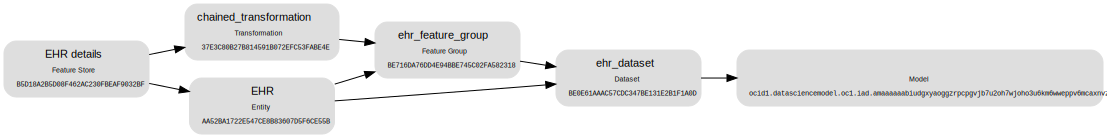

In [31]:
dataset.show()

In [32]:
dataset.profile().show()

+------+--------------------+--------------------+-----------+--------------------+--------------------+-------------------+----------------+--------+-----------+----------+----------------+----------------+
|format|                  id|                name|description|            location|           createdAt|       lastModified|partitionColumns|numFiles|sizeInBytes|properties|minReaderVersion|minWriterVersion|
+------+--------------------+--------------------+-----------+--------------------+--------------------+-------------------+----------------+--------+-----------+----------+----------------+----------------+
| delta|bef3e45f-ccdc-4ec...|aa52ba1722e547ce8...|       null|oci://MetaStore-M...|2023-12-12 03:55:...|2023-12-12 03:55:48|              []|       2|      42226|        {}|               1|               2|
+------+--------------------+--------------------+-----------+--------------------+--------------------+-------------------+----------------+--------+-----------+------

In [33]:
dataset.preview().show()

  dataset.preview().show()



+-----------+------------+-----------+---------+-----------+---+---+------+
|HAEMATOCRIT|HAEMOGLOBINS|ERYTHROCYTE|LEUCOCYTE|THROMBOCYTE|AGE|SEX|SOURCE|
+-----------+------------+-----------+---------+-----------+---+---+------+
|       33.8|        11.2|        4.0|      9.0|        140| 47|  0|     0|
|       39.5|        13.2|       4.55|      2.3|         74| 47|  0|     0|
|       31.6|         9.6|       4.52|      7.9|        301| 47|  0|     0|
|       33.1|        10.9|       3.97|      8.2|        143| 47|  0|     0|
|       39.3|        13.3|       4.49|      3.3|         50| 47|  0|     0|
|       40.1|        12.2|       5.53|      6.4|        326| 47|  0|     0|
|       39.7|        12.7|       4.63|      4.0|        167| 47|  1|     0|
|       25.0|         8.1|        3.1|      5.3|        125| 47|  1|     0|
|       26.4|         8.0|        3.1|     10.0|         64| 47|  1|     0|
|       33.1|        11.5|       3.94|     13.3|        248| 47|  1|     0|
+-----------

<a id='ref'></a>
# References

- [ADS Library Documentation](https://accelerated-data-science.readthedocs.io/en/latest/index.html)
- [Data Science YouTube Videos](https://www.youtube.com/playlist?list=PLKCk3OyNwIzv6CWMhvqSB_8MLJIZdO80L)
- [OCI Data Science Documentation](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm)
- [Oracle Data & AI Blog](https://blogs.oracle.com/datascience/)